In [1]:
import sys
import os

import torch
import random
import warnings
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import torchvision
import torchvision.transforms.functional as TF
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from cca_zoo.linear import rCCA
from joblib import Parallel, delayed

warnings.filterwarnings("ignore")

# Import MI files
from utils import *
from models import *
from estimators import *
from trainers import *

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['figure.dpi'] = 100

# Set global font sizes for better readability
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'axes.labelsize': 16})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'legend.fontsize': 15})

# To-do list:
- [X] New dataset and dataloader setup
- [X] Train/test split as function so repeated calls get different splits
- [/] Implement parallel training with shared memory
- [X] Make infoNCE inference chunked so it can run on large datasets
- [] Kernel convolution with spikes to get continuous form, run MI

In [2]:
# Check if CUDA or MPS is running
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = "CPU"

print(f'Device: {device}')

Device: cuda


In [3]:
# A helper plotting function
def plot_activity(X, Y, title="Neural and Muscle Activity", cmap='viridis'):
    """
    Plots raster-like visualizations of neural (X) and muscle (Y) activity.
    
    Parameters:
        X (numpy.ndarray): Neural activity tensor of shape (num_neurons, num_time_points).
        Y (numpy.ndarray): Muscle activity tensor of shape (num_muscles, num_time_points).
        title (str, optional): Title of the plot.
        cmap (str, optional): Colormap for the heatmap (default: 'viridis').
    """
    # Detect non-zero activity regions
    def find_active_region(activity):
        """Finds the first region with non-zero activity."""
        non_zero_cols = np.any(activity > 0, axis=0)
        active_start = np.argmax(non_zero_cols)
        active_end = len(non_zero_cols) - np.argmax(non_zero_cols[::-1])
        return active_start, active_end

    # Find active regions for X and Y
    x_active_start, x_active_end = find_active_region(X)
    y_active_start, y_active_end = find_active_region(Y)

    # Determine the shared time range for plotting
    start = min(x_active_start, y_active_start)
    end = max(x_active_end, y_active_end)

    # Clip the data to the active region
    X_plot = X[:, start:end]
    Y_plot = Y[:, start:end]

    # Create the figure and subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'hspace': 0.3})

    # Plot neural activity (X)
    im_x = axes[0].imshow(
        X_plot, aspect='auto', cmap=cmap, interpolation='none',
        extent=[start, end, 0, X.shape[0]], origin='lower'
    )
    axes[0].set_title("Neural Activity")
    axes[0].set_ylabel("Neurons")
    fig.colorbar(im_x, ax=axes[0], orientation='vertical', label="Activity")

    # Plot muscle activity (Y)
    im_y = axes[1].imshow(
        Y_plot, aspect='auto', cmap=cmap, interpolation='none',
        extent=[start, end, 0, Y.shape[0]], origin='lower'
    )
    axes[1].set_title("Muscle Activity")
    axes[1].set_xlabel("Time Points")
    axes[1].set_ylabel("Muscles")
    fig.colorbar(im_y, ax=axes[1], orientation='vertical', label="Activity")

    # Add overall title
    fig.suptitle(title, fontsize=16)

    # Show the plot
    plt.show()

Neural Activity (X): (46, 1526608)
Muscle Activity (Y): (10, 1526608)
Neuron Labels: ['32', '29', '81', '53', '51', '27', '75', '33', '28', '52', '50', '26', '10', '23', '49', '5', '31', '43', '39', '34', '55', '17', '37', '47', '82', '12', '104', '7', '57', '8', '19', '97', '11', '35', '13', '15', '100', '16', '21', '38', '56', '36', '66', '103', '18', '30']
Muscle Labels: ['ldvm', 'lax', 'rdlm', 'rax', 'rba', 'rdvm', 'lsa', 'ldlm', 'rsa', 'lba']


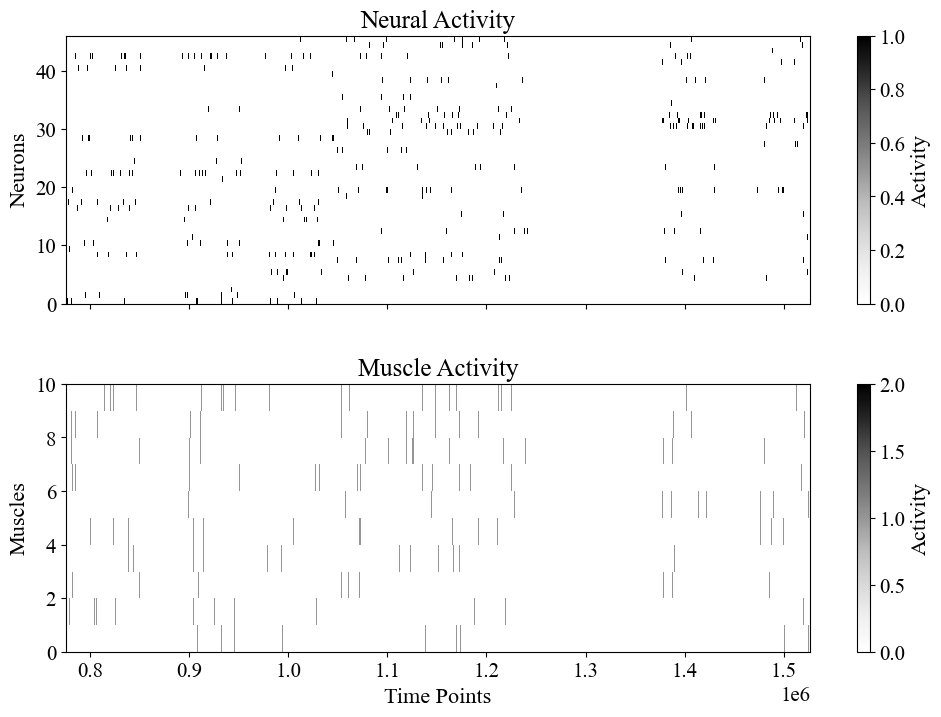

In [4]:
# Read the data and have some binning
# data_dir = "/Users/leo/Desktop/ResearchPhD/VNCMP/localdata/data_for_python"
data_dir = os.path.join(os.getcwd(), '..', 'data_for_python')
X, Y, x_labels, y_labels = process_spike_data(os.path.join(data_dir, '2025-03-12_1'), 0.001)
print(f"Neural Activity (X): {X.shape}")
print(f"Muscle Activity (Y): {Y.shape}") 
print("Neuron Labels:", x_labels)
print("Muscle Labels:", y_labels)

plot_activity(X,Y, title=None, cmap='Greys')

In [5]:
params = {
    # Optimizer parameters (for training)
    'epochs': 100,
    'batch_size': 128,
    'learning_rate': 5e-4,
    'n_trials': 2,
    'patience': 30,
    'min_delta': 0.001,
    # Critic parameters for DSIB or DVSIB (for the estimator), except embed_dim, which changes with training
    'Nx': X.shape[0],
    'Ny': Y.shape[0],
    'layers': 2,
    'hidden_dim': 256,
    'activation': 'leaky_relu',
    'beta': 512,
    'max_dz': 10, # max value for embed_dim that we search for
    'estimator': 'infonce', # Estimator: infonce or smile_5. See estimators.py for all options
    'mode': 'sep', # Almost always we'll use separable
    'chunked_inference': True, 
    'chunk_size': 1000,
}

In [ ]:
# Make into tensors
X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)
dataset = BatchedDataset(X, Y, params['batch_size'])
full_dataset = create_data_split(dataset, train_fraction=0.95, device=device)

In [35]:
# Compare chunked and un-chunked to make sure both line up
torch.cuda.empty_cache()
chunked_params = {**params, 'embed_dim': 4, 'chunked_inference': True}
# unchunked_params = {**params, 'embed_dim': 4, 'chunked_inference': False}
mis_chunk, mis_test_chunk = train_model(DSIB, full_dataset, chunked_params)
# mis_unchunk, mis_test_unchunk = train_model(DSIB, full_dataset, unchunked_params)

Epoch: 1, DSIB, train: 0.004410743713378906, test: 0.005707740783691406
Epoch: 2, DSIB, train: 0.004252433776855469, test: 0.005167961120605469
Epoch: 3, DSIB, train: 0.004467964172363281, test: 0.004799842834472656
Epoch: 4, DSIB, train: 0.0044708251953125, test: 0.004471778869628906
Epoch: 5, DSIB, train: 0.00498199462890625, test: 0.004740715026855469
Epoch: 6, DSIB, train: 0.005476951599121094, test: 0.004736900329589844
Epoch: 7, DSIB, train: 0.005863189697265625, test: 0.004673957824707031
Epoch: 8, DSIB, train: 0.0062713623046875, test: 0.004746437072753906
Epoch: 9, DSIB, train: 0.006594657897949219, test: 0.0044403076171875
Epoch: 10, DSIB, train: 0.006739616394042969, test: 0.0038805007934570312
Epoch: 11, DSIB, train: 0.006992340087890625, test: 0.0034360885620117188
Epoch: 12, DSIB, train: 0.007132530212402344, test: 0.00279998779296875
Epoch: 13, DSIB, train: 0.0072956085205078125, test: 0.0025005340576171875
Epoch: 14, DSIB, train: 0.007129669189453125, test: 0.0016841888

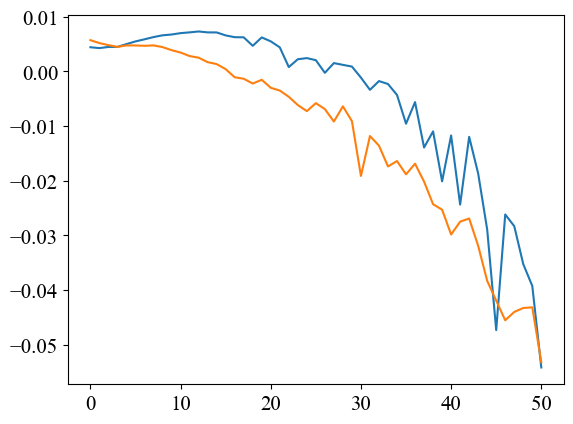

In [37]:
plt.figure()
plt.plot(mis_chunk)
plt.plot(mis_test_chunk)

In [10]:
_, (test_X, test_Y), (eval_X, eval_Y) = full_dataset
test_X.shape

torch.Size([20736, 46])

In [ ]:
# Empty arrays and do the run, will take forever
mi = {}
mi_test = {}

for dz in range(1, params['max_dz']+1):
    this_params = {**params, 'embed_dim': dz} # Choose dz
    print(f'Starting dz = {dz}')
    for j in range(params['n_trials']):
        print(f'dz = {dz}, trial = {j+1}')
        torch.cuda.empty_cache()
        mis, mis_test = train_model(DSIB, full_dataset, this_params)
        
        # Store results
        mi[f"trial_{j}_dz_{dz}"] = mis
        mi_test[f"trial_{j}_dz_{dz}"] = mis_test


Starting dz = 1
dz = 1, trial = 1
Epoch: 1, DSIB, train: 0.3059539794921875, test: 0.3244031071662903
Epoch: 2, DSIB, train: 0.34774112701416016, test: 0.3954346179962158
Epoch: 3, DSIB, train: 0.31298065185546875, test: 0.4106545150279999
Epoch: 4, DSIB, train: 0.35773658752441406, test: 0.47942787408828735
Epoch: 5, DSIB, train: 0.2803535461425781, test: 0.43292683362960815
Epoch: 6, DSIB, train: 0.3235607147216797, test: 0.47495579719543457
Epoch: 7, DSIB, train: 0.2793703079223633, test: 0.4533478021621704
Epoch: 8, DSIB, train: 0.37558937072753906, test: 0.5060944557189941
Epoch: 9, DSIB, train: 0.24801921844482422, test: 0.4513174891471863
Epoch: 10, DSIB, train: 0.4577798843383789, test: 0.5433735847473145
Epoch: 11, DSIB, train: 0.30545902252197266, test: 0.49845194816589355
Epoch: 12, DSIB, train: 0.33547115325927734, test: 0.5274474024772644
Epoch: 13, DSIB, train: -0.007685661315917969, test: 0.4273027777671814
Epoch: 14, DSIB, train: 0.2722482681274414, test: 0.473684787750

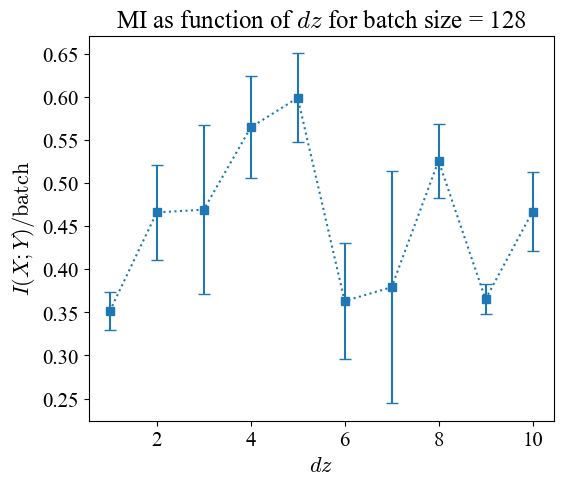

In [8]:
EMA_SPAN = 5 # smoothing, set to 1 if you don't want smoothing
dz_means = []
dz_stds = []

fig, ax = plt.subplots(figsize=(6,5))
for dz in range(1, params['max_dz']+1):
    mi_trials = []
    for j in range(params['n_trials']):
        key = f"trial_{j}_dz_{dz}"

        # Define sigma, a small number is usually the best choice
        sigma=1 # (or 2 at most)
        # Convert Nan to zeros and smooth
        train = gaussian_filter1d(np.nan_to_num(mi[key]), sigma=sigma)
        test = gaussian_filter1d(np.nan_to_num(mi_test[key]), sigma=sigma)

        # Pick the epoch with highest test value and get corresponding train
        best = np.argmax(test)
        
        mi_trials.append(train[best])

    dz_means.append(np.mean(np.array(mi_trials)).flatten())
    dz_stds.append(np.std(np.array(mi_trials)).flatten())


b = ax.errorbar(
    range(1, params['max_dz']+1), np.array(dz_means).flatten(), 
    yerr=np.array(dz_stds).flatten(), 
    fmt='s:', capsize=4)

# Set title and scales
ax.set_title(r"MI as function of $dz$ for batch size = "+str(params['batch_size']))
ax.set_xlabel(r'$dz$')
ax.set_ylabel(r'$I(X;Y)/\text{batch}$');


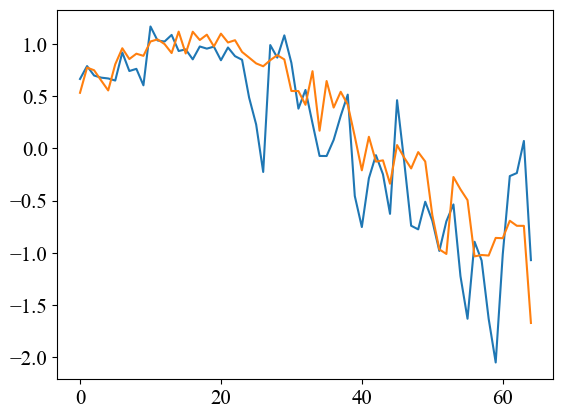

In [23]:
plt.plot(mi['trial_1_dz_5'] * np.log2(np.e))
plt.plot(mi_test['trial_1_dz_5'] * np.log2(np.e))

In [36]:
13 * 10 * 5 * 10 / 60 / 12

9.027777777777777

Okay, so running on the whole dataset takes a long time. 

Immediate fixes: 
- Drop patience down to ~40

Questions:
- Is most of this training, or is evaluation still slow? We can do test/eval on less data if need be
- 

Scheme for a given moth:
- X embedding dimension sizes
- Y repeats at each embedding dim size
- Z batch sizes